In [1]:
 import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras import models,layers
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
cnn = tf.keras.models.Sequential()

In [3]:
model=models

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
n_classes=3

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory('plant village',
      seed=123,
       shuffle=True,
     image_size=(IMAGE_SIZE,IMAGE_SIZE),
     batch_size= BATCH_SIZE)  

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

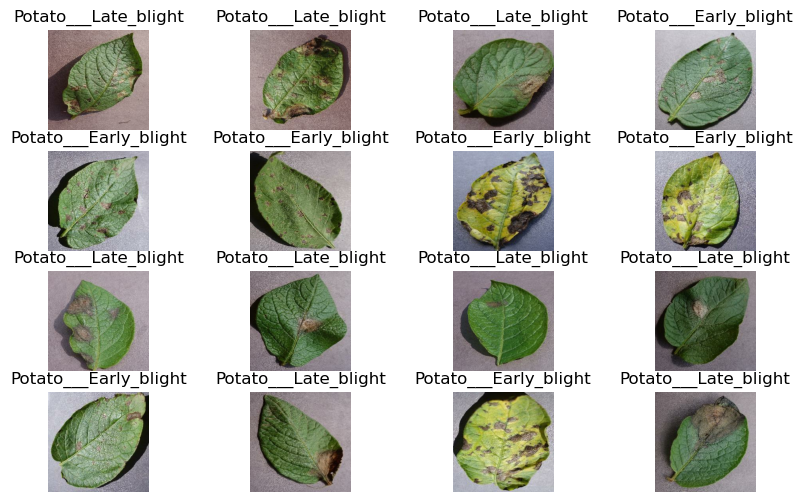

In [8]:
plt.figure(figsize=(10,6))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype("uint8"))

In [9]:
train_size=0.7
len(dataset)*train_size

47.599999999999994

In [10]:
train_ds=dataset.take(47)
len(train_ds)

47

In [11]:
test_ds=dataset.skip(47)
len(test_ds)

21

In [12]:
val_size=0.15
len(dataset)*val_size

10.2

In [13]:
val_ds=test_ds.take(10)
len(val_ds)

10

In [14]:
test_ds=test_ds.skip(10)
len(test_ds)

11

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.7,val_split=0.15,test_split=0.15,shuffle=True,shuffle_size=1000):
    assert(train_split+test_split+val_split)==1
    ds_size=len(ds)
    if shuffle:
     ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [16]:
train_ds,test_ds,val_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

47

In [18]:
len(val_ds)

11

In [19]:
len(test_ds)

10

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
rescale_and_resize=tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1/255),layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)])

In [22]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.1)])

In [23]:
train_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    rescale_and_resize,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
tf.debugging.disable_traceback_filtering()

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
47/47 [==============================] - 60s 1s/step - loss: 0.9250 - accuracy: 0.4814 - val_loss: 0.8814 - val_accuracy: 0.5142
Epoch 2/50
47/47 [==============================] - 63s 1s/step - loss: 0.7559 - accuracy: 0.6070 - val_loss: 0.6228 - val_accuracy: 0.7244
Epoch 3/50
47/47 [==============================] - 64s 1s/step - loss: 0.5020 - accuracy: 0.7699 - val_loss: 0.6762 - val_accuracy: 0.6364
Epoch 4/50
47/47 [==============================] - 66s 1s/step - loss: 0.4045 - accuracy: 0.8324 - val_loss: 0.6405 - val_accuracy: 0.6591
Epoch 5/50
47/47 [==============================] - 67s 1s/step - loss: 0.3599 - accuracy: 0.8524 - val_loss: 0.3399 - val_accuracy: 0.8551
Epoch 6/50
47/47 [==============================] - 67s 1s/step - loss: 0.2485 - accuracy: 0.8969 - val_loss: 0.2659 - val_accuracy: 0.8949
Epoch 7/50
47/47 [==============================] - 68s 1s/step - loss: 0.1841 - accuracy: 0.9255 - val_loss: 0.2619 - val_accuracy: 0.8835
Epoch 8/50
47/47 [==

In [36]:
score=model.evaluate(test_ds)

10/10 [==============================] - 6s 260ms/step - loss: 0.1261 - accuracy: 0.9656


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 213ms/step
predicted label: Potato___Early_blight
first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 219ms/step
predicted label: Potato___Late_blight


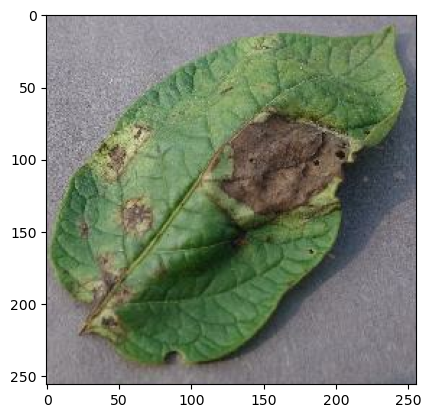

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):
    
    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


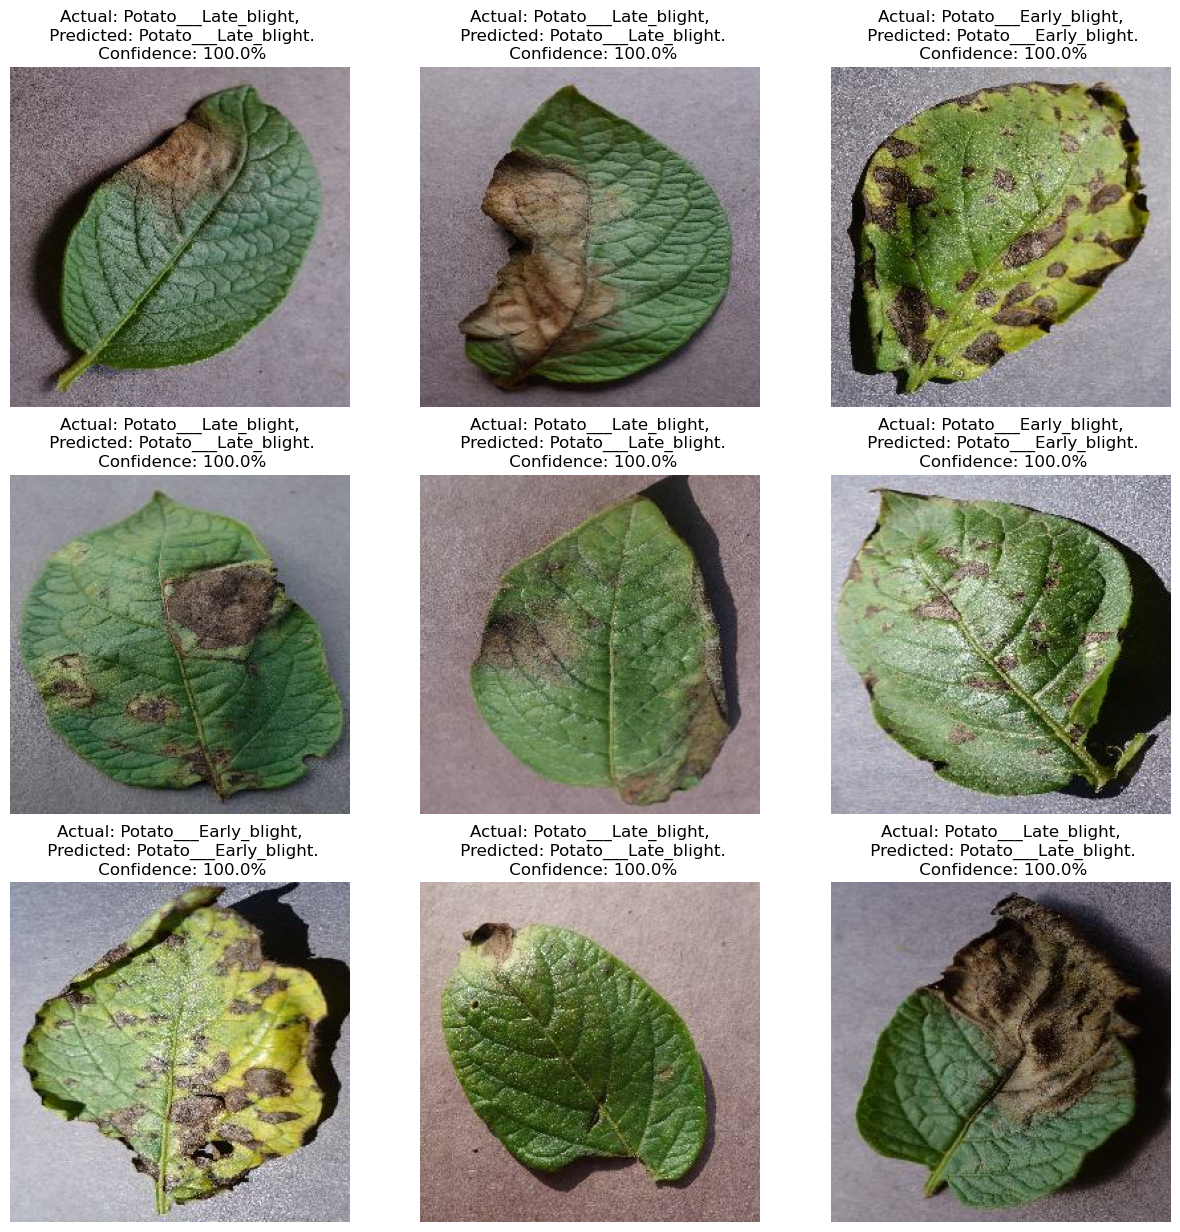

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")